In [1]:
library(hdf5r)
library(Seurat)
library(purrr)
library(dplyr)
library(stringr)
library(harmony)
library(DoubletFinder)
library(ggplot2)
library(ggpubr)
library(plyr)
library(pheatmap)
library(cowplot)

Attaching SeuratObject


载入程辑包：‘purrr’


The following object is masked from ‘package:hdf5r’:

    flatten_df



载入程辑包：‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


载入需要的程辑包：Rcpp

------------------------------------------------------------------------------

You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)

------------------------------------------------------------------------------


载入程辑包：‘plyr’


The following object is masked from ‘package:ggpubr’:

    mutate


The following objects are masked from ‘package:dplyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following object is masked from ‘package:purrr’:

    compact



载入程辑包：‘cowplot’


The following object is masked 

In [2]:
cd4t = readRDS('~/HPV/res/public_rna/seurat_rds/cd4t.rds')

In [3]:
proliferation_genes = read.table('~/HPV/ref/pathways/cancersea/raw/Cell_Cycle.txt',header = TRUE,sep = '\t')
proliferation_genes = c(proliferation_genes$GeneName, cc.genes$g2m.genes, cc.genes$s.genes)

In [4]:
marker_genes = c("CCR7","TCF7","LEF1","SELL",'KLF2',"IL7R","CD27","IL2RA","TIMP1","EOMES","ITGAE","ITGA1","CD69","XCL1","ZNF683","GZMK","GZMA","GZMB","GZMH","NKG7","GNLY","IL17A","RORC","CXCR5","PDCD1","CXCL13","IL21","TBX21","IFNG","FOXP3","CCL5")

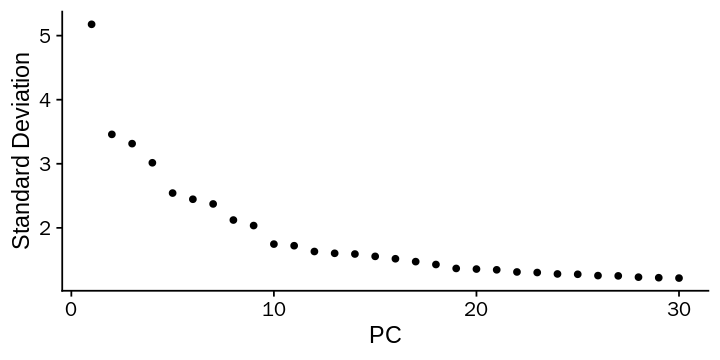

In [5]:
temp = cd4t
cd4t = CreateSeuratObject(counts = cd4t@assays$RNA@counts, project = "cd4t") %>% 
    NormalizeData(verbose = FALSE) %>%
    FindVariableFeatures(selection.method = "vst", nfeatures = 600)
VariableFeatures(cd4t) = unique(c(marker_genes, cd4t@assays$RNA@var.features))
cd4t = ScaleData(cd4t, verbose = FALSE) %>% 
    RunPCA(npcs = 30, verbose = FALSE)
options(repr.plot.width = 6, repr.plot.height = 3)
ElbowPlot(cd4t,ndims = 30)

In [6]:
cd4t@meta.data = temp@meta.data
cd4t = RunHarmony(object = cd4t, group.by.vars = 'Patient', verbose = FALSE, reduction = 'pca') %>%    
    RunUMAP(reduction = "harmony", dims = 1:15, verbose = FALSE) %>%
    FindNeighbors(reduction = "harmony", dims = 1:15, verbose = FALSE) %>%
    FindClusters(resolution = 1.5, verbose = FALSE)

Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is Seurat..ProjectDim.RNA.harmony; see ?make.names for more details on syntax validity”
Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


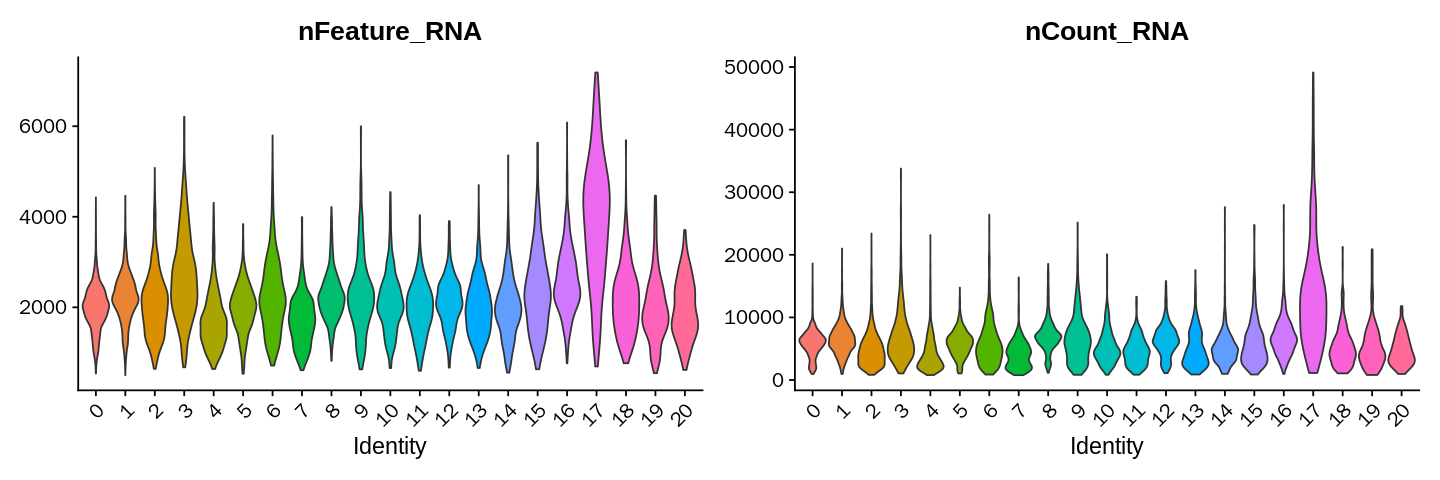

In [7]:
options(repr.plot.width = 12, repr.plot.height = 4)
VlnPlot(cd4t,features = c("nFeature_RNA", "nCount_RNA"),pt.size = 0)

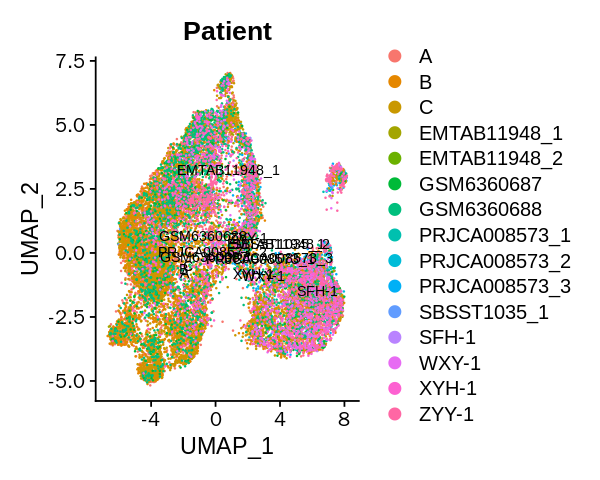

In [8]:
options(repr.plot.width = 5, repr.plot.height = 4)
DimPlot(cd4t, group.by = 'Patient',label = TRUE,label.size = 3)

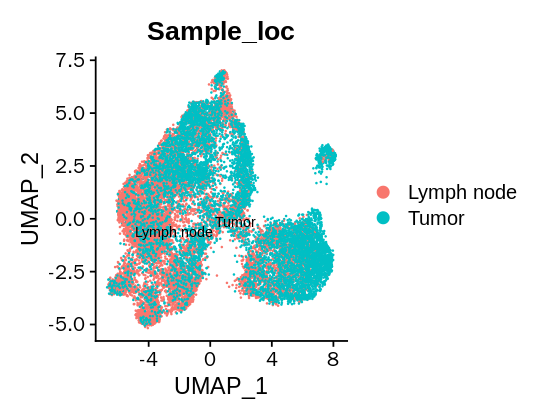

In [9]:
options(repr.plot.width = 4.5, repr.plot.height = 3.5)
DimPlot(cd4t, group.by = 'Sample_loc',label = TRUE,label.size = 3)

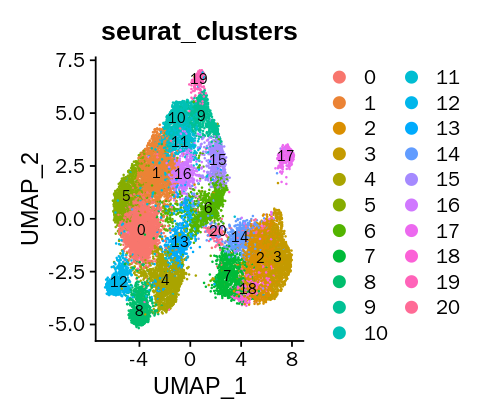

In [10]:
options(repr.plot.width = 4, repr.plot.height = 3.5)
DimPlot(cd4t, group.by = 'seurat_clusters',label = TRUE,label.size = 3)

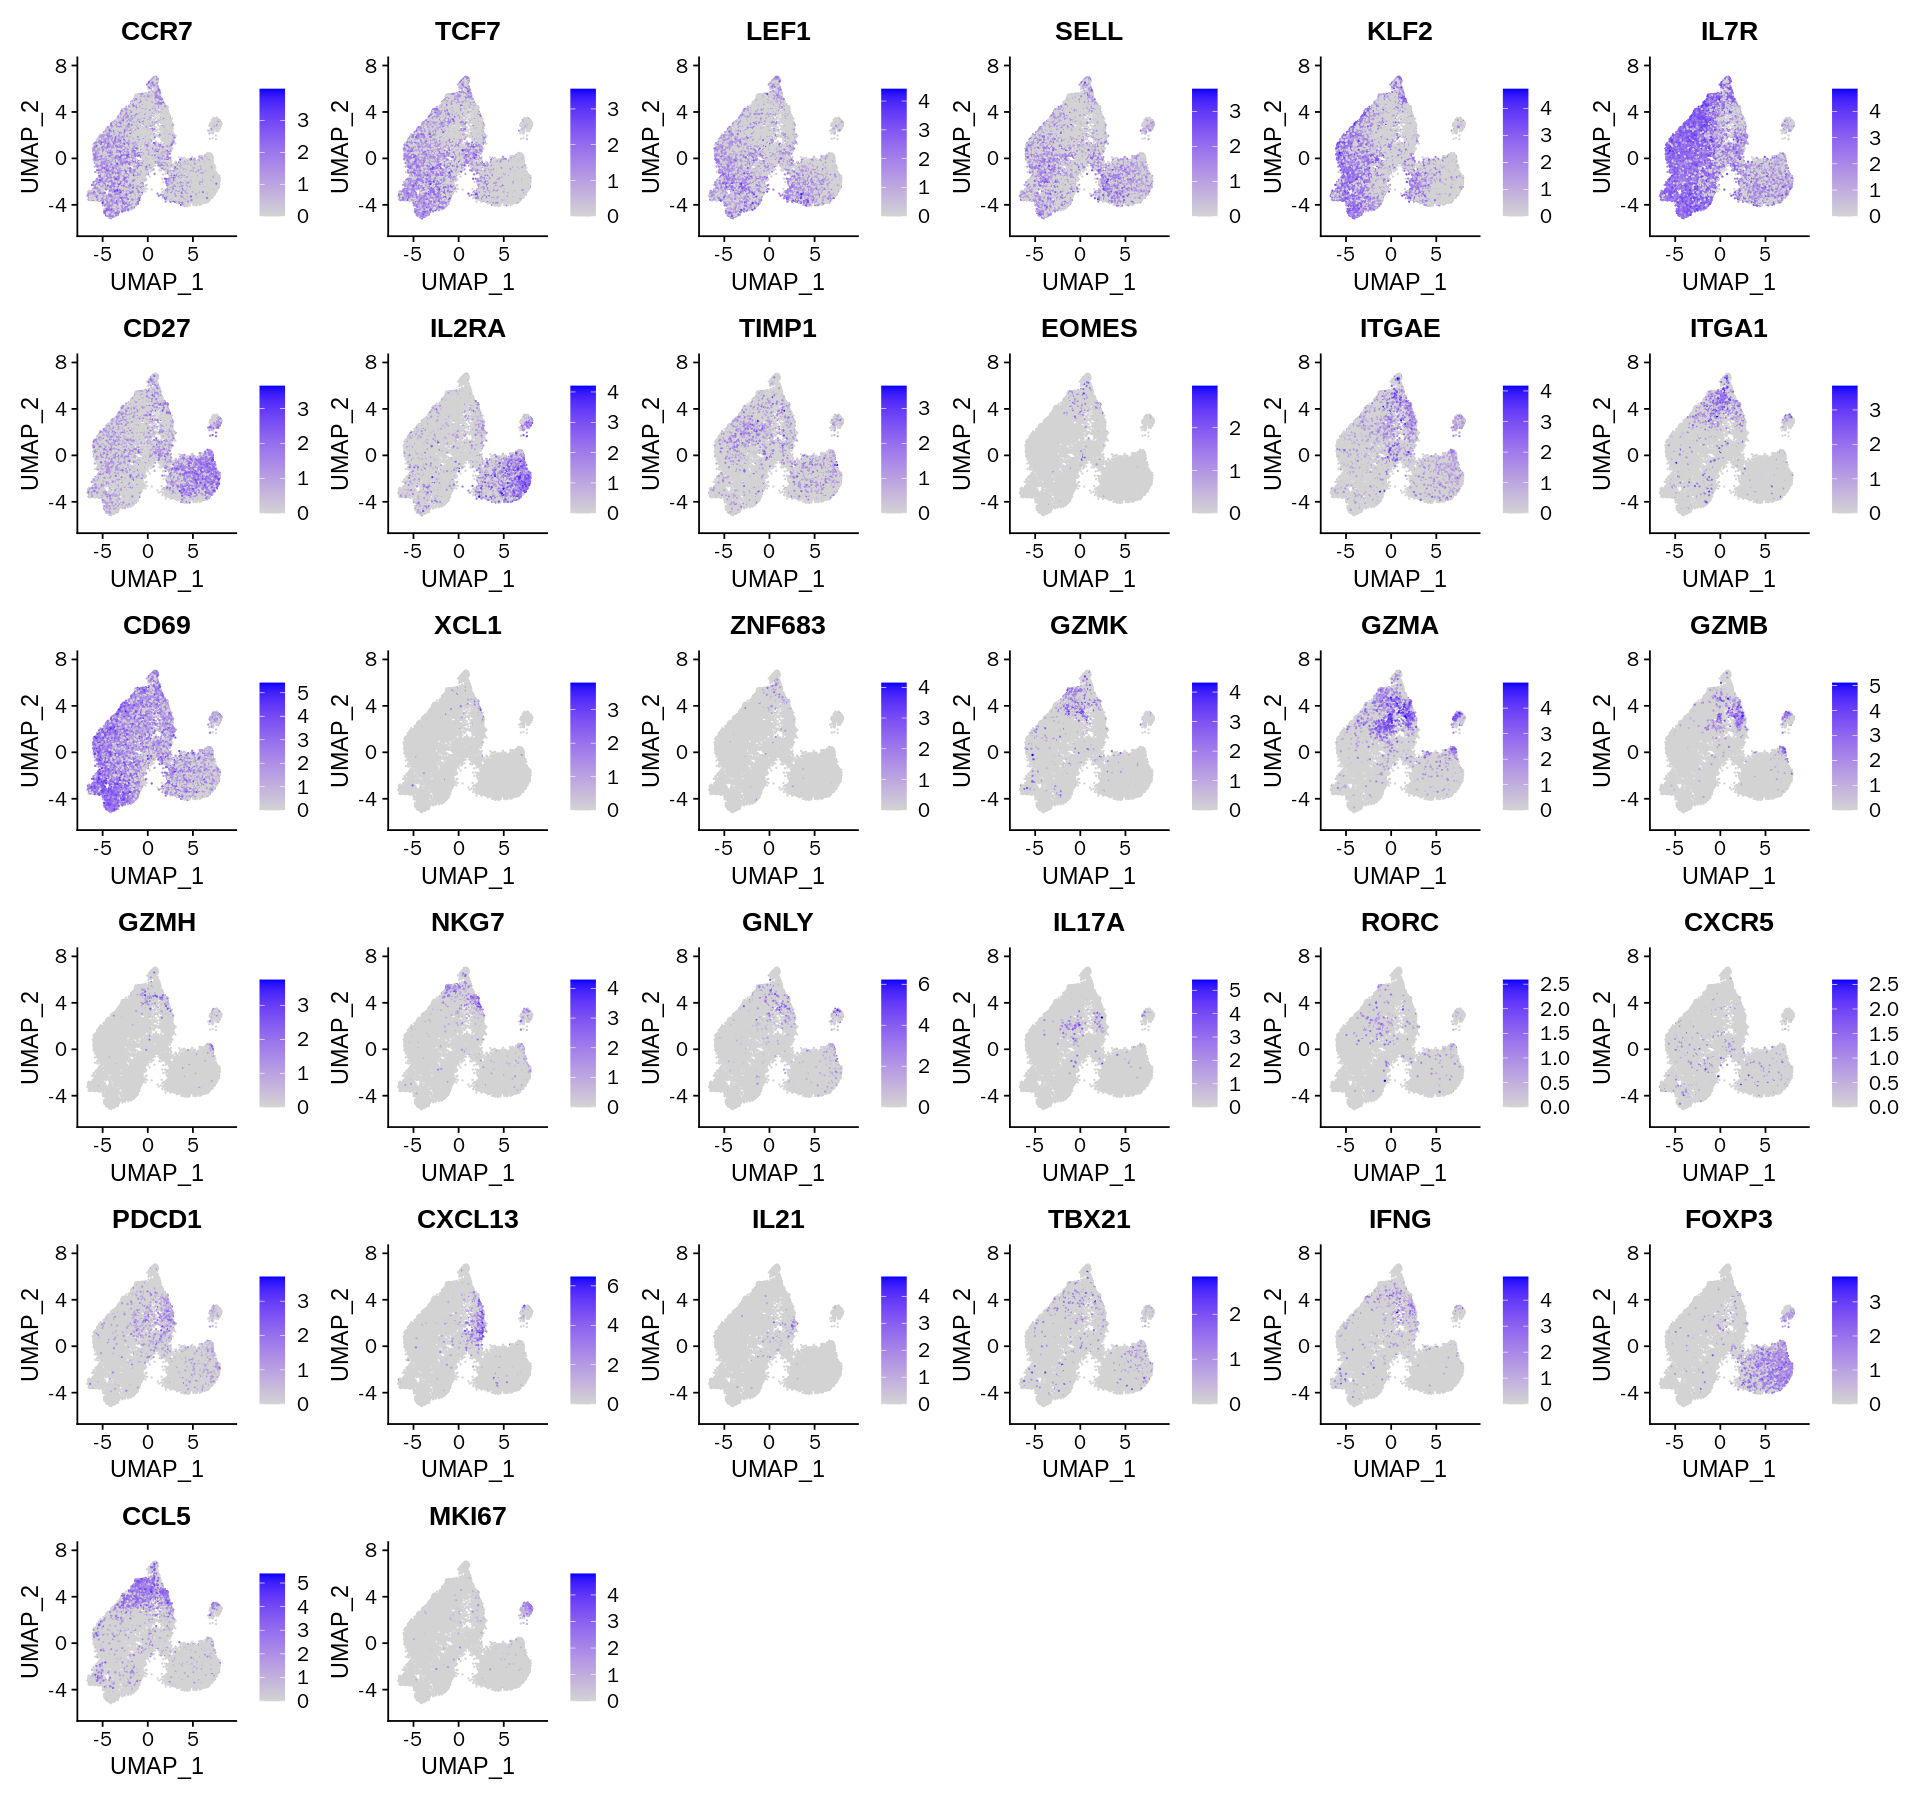

In [11]:
options(repr.plot.width = 16, repr.plot.height = 15)
FeaturePlot(cd4t,features = c(marker_genes,'MKI67'),ncol = 6,pt.size = 0.001)

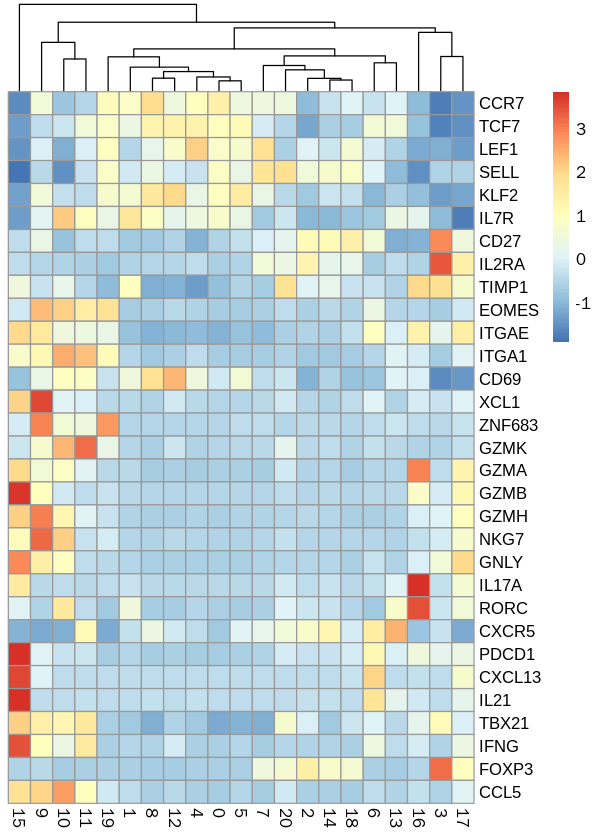

In [12]:
gene_cell_exp <- AverageExpression(cd4t,
                                   features = c(marker_genes),
                                   group.by = 'seurat_clusters',
                                   slot = 'data') 
gene_cell_exp <- as.data.frame(gene_cell_exp$RNA)
marker_exp <- t(scale(t(gene_cell_exp),scale = T,center = T))
options(repr.plot.width = 5, repr.plot.height = 7)
pheatmap(marker_exp,cluster_rows = FALSE)

In [13]:
low_res = cd4t
low_res = FindClusters(low_res, resolution = 0.8, verbose = FALSE)

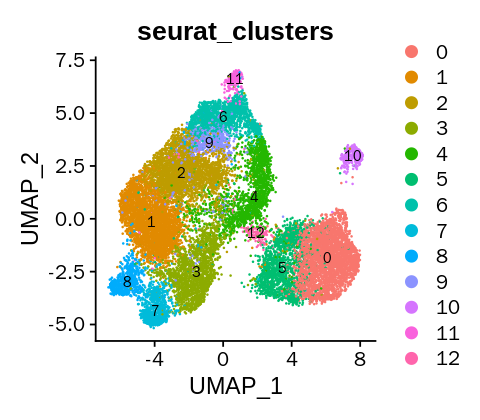

In [14]:
options(repr.plot.width = 4, repr.plot.height = 3.5)
DimPlot(low_res, group.by = 'seurat_clusters',label = TRUE,label.size = 3)

In [15]:
cd4t$minor = 'cd4t'
cd4t$minor[cd4t$seurat_clusters %in% c('6')] = 'CD4Tfh1'
cd4t$minor[cd4t$seurat_clusters %in% c('13')] = 'CD4Tfh2'
cd4t$minor[cd4t$seurat_clusters %in% c('15')] = 'CD4Th1'
cd4t$minor[cd4t$seurat_clusters %in% c('16')] = 'CD4Th17'
cd4t$minor[cd4t$seurat_clusters %in% c('17')] = 'CD4T_MKI67'
cd4t$minor[cd4t$seurat_clusters %in% c('20')] = 'CD4Treg1'
cd4t$minor[cd4t$seurat_clusters %in% c('14')] = 'CD4Treg2'
cd4t$minor[cd4t$seurat_clusters %in% c('7')] = 'CD4Treg3'
cd4t$minor[cd4t$seurat_clusters %in% c('2','3','18')] = 'CD4Treg4'

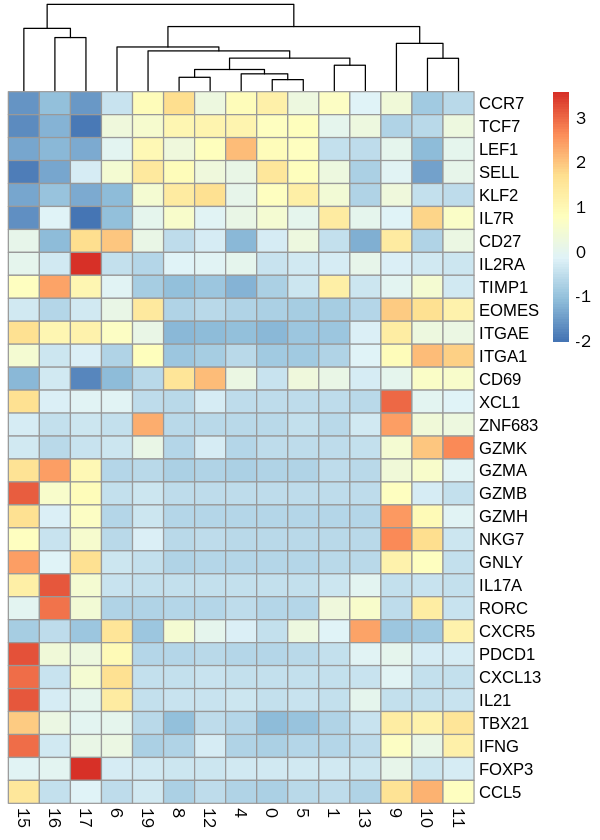

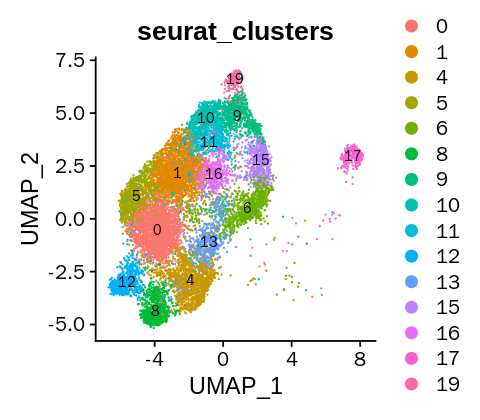

In [16]:
# subtype
sub_clustes = setdiff(cd4t$seurat_clusters,c(7,2,3,18,20,14))
gene_cell_exp <- AverageExpression(cd4t[,cd4t$seurat_clusters %in% sub_clustes],
                                   features = marker_genes,
                                   group.by = 'seurat_clusters',
                                   slot = 'data') 
gene_cell_exp <- as.data.frame(gene_cell_exp$RNA)
marker_exp <- t(scale(t(gene_cell_exp),scale = T,center = T))
options(repr.plot.width = 5, repr.plot.height = 7)
pheatmap(marker_exp,cluster_rows = FALSE)
 
options(repr.plot.width = 4, repr.plot.height = 3.5)
DimPlot(cd4t[,cd4t$seurat_clusters %in% sub_clustes], group.by = 'seurat_clusters',label = TRUE,label.size = 3,pt.size = 0.001)

In [17]:
cd4t$minor[cd4t$seurat_clusters %in% c('12')] = 'CD4Tnaive1'
cd4t$minor[cd4t$seurat_clusters %in% c('8')] = 'CD4Tnaive2'
cd4t$minor[cd4t$seurat_clusters %in% c('4')] = 'CD4Tnaive3'
cd4t$minor[cd4t$seurat_clusters %in% c('0')] = 'CD4Tnaive4'
cd4t$minor[cd4t$seurat_clusters %in% c('5')] = 'CD4Tnaive5'

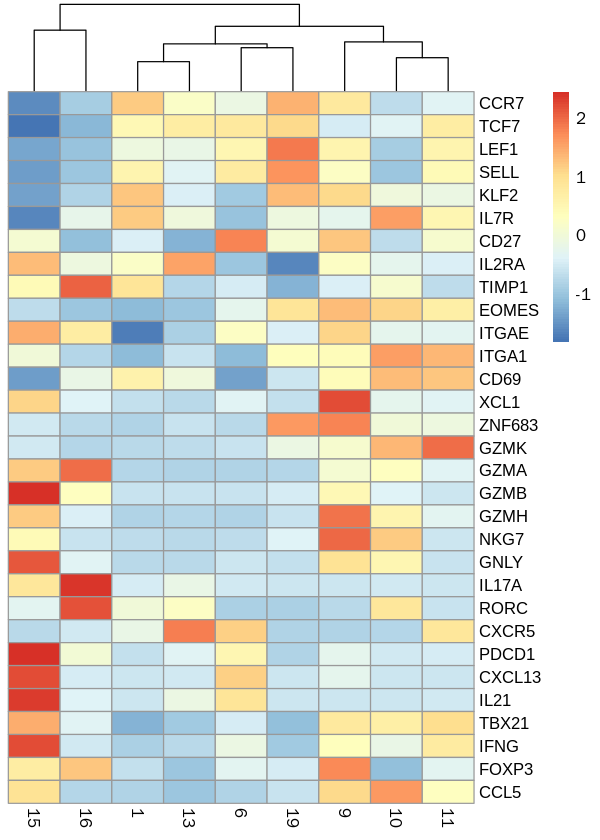

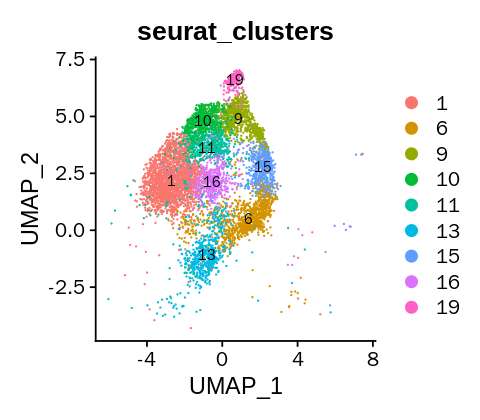

In [18]:
# subtype
sub_clustes = c(1,13,6,16,11,15,10,9,19)
gene_cell_exp <- AverageExpression(cd4t[,cd4t$seurat_clusters %in% sub_clustes],
                                   features = marker_genes,
                                   group.by = 'seurat_clusters',
                                   slot = 'data') 
gene_cell_exp <- as.data.frame(gene_cell_exp$RNA)
marker_exp <- t(scale(t(gene_cell_exp),scale = T,center = T))
options(repr.plot.width = 5, repr.plot.height = 7)
pheatmap(marker_exp,cluster_rows = FALSE)
 
options(repr.plot.width = 4, repr.plot.height = 3.5)
DimPlot(cd4t[,cd4t$seurat_clusters %in% sub_clustes], group.by = 'seurat_clusters',label = TRUE,label.size = 3,pt.size = 0.001)

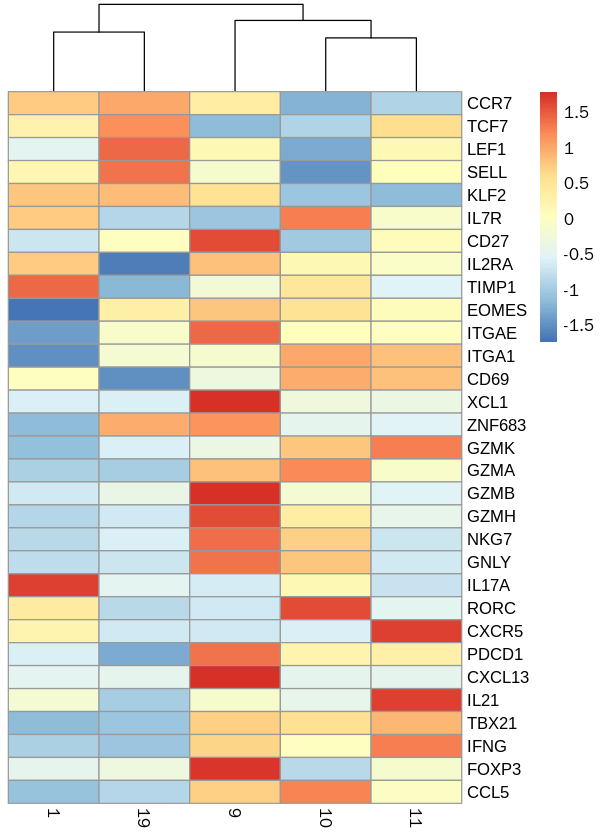

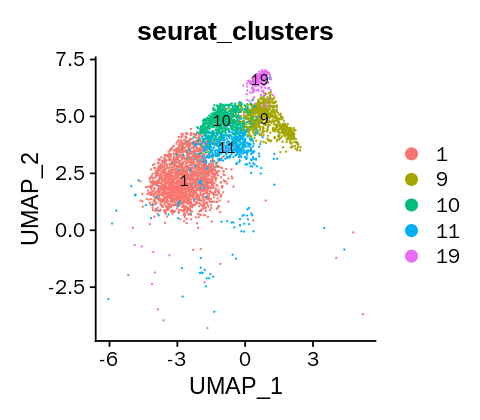

In [19]:
# mem
sub_clustes = c(1,11,10,9,19)
gene_cell_exp <- AverageExpression(cd4t[,cd4t$seurat_clusters %in% sub_clustes],
                                   features = marker_genes,
                                   group.by = 'seurat_clusters',
                                   slot = 'data') 
gene_cell_exp <- as.data.frame(gene_cell_exp$RNA)
marker_exp <- t(scale(t(gene_cell_exp),scale = T,center = T))
options(repr.plot.width = 5, repr.plot.height = 7)
pheatmap(marker_exp,cluster_rows = FALSE)
 
options(repr.plot.width = 4, repr.plot.height = 3.5)
DimPlot(cd4t[,cd4t$seurat_clusters %in% sub_clustes], group.by = 'seurat_clusters',label = TRUE,label.size = 3,pt.size = 0.001)

In [20]:
cd4t$minor[cd4t$seurat_clusters %in% c('1')] = 'CD4Tcm1'
cd4t$minor[cd4t$seurat_clusters %in% c('19')] = 'CD4Tcm2'
cd4t$minor[cd4t$seurat_clusters %in% c('11')] = 'CD4Tem'
cd4t$minor[cd4t$seurat_clusters %in% c('10')] = 'CD4Trm1'
cd4t$minor[cd4t$seurat_clusters %in% c('9')] = 'CD4Trm2'

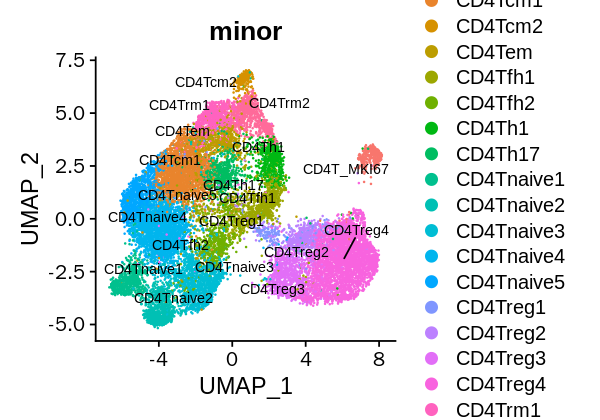

In [21]:
options(repr.plot.width = 5, repr.plot.height = 3.5)
DimPlot(cd4t, group.by = 'minor',label = TRUE,label.size = 3, repel = TRUE)

In [22]:
saveRDS(cd4t,file = '~/HPV/res/public_rna/seurat_rds/cd4t.rds')